# Importaciones

In [63]:
# Sistema
import os
import copy
import time
# Gráficas
import matplotlib.pyplot as plt
# Matemática y estructura
import numpy as np
import pandas as pd
# Logging
import logging
# Inteligencia artificial
import torch
# Imágenes
from PIL import Image
# (Torch)
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision import tv_tensors
# Aumento de datos
from torchvision.transforms import v2
# Dataset
from collections import defaultdict
# Modelo
from torchvision.models.mobilenetv3 import MobileNet_V3_Large_Weights
from torchvision.models.mobilenetv3 import mobilenet_v3_large
# Capas
import torch.nn as nn
# Entrenamiento
import torch.optim as optim
# Métricas
from sklearn.metrics import recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score

# Aumento de datos

## Creación del Pipeline (Personalizado)

In [64]:
# Constantes de transformaciones aceptadas por MobileNet
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
_resize = 256
_crop = 224
_mean = [0.485, 0.456, 0.406]
_std = [0.229, 0.224, 0.225]

In [65]:
# Pipeline
transform_augmented_entorno_abierto = v2.Compose([
    # Transformaciones de aumento de datos \
    v2.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.RandomVerticalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.ColorJitter(brightness=0.2, contrast=0.1), # Ajuste aleatorio de brillo y contraste en +-0.2
    # Transformaciones requeridas
    v2.Resize(_resize, interpolation=v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(_crop),
    # Conversiones y normalizaciones
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=_mean, std=_std),
])

In [ ]:
# Pipeline
transform_augmented_extrapolacion_brasil = v2.Compose([
    # Transformaciones de aumento de datos \
    v2.RandomHorizontalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.RandomVerticalFlip(p=0.5),  # Volteo horizontal con una probabilidad del 50%
    v2.ColorJitter(brightness=0.2, contrast=0.1), # Ajuste aleatorio de brillo y contraste en +-0.2
    # Transformaciones requeridas
    v2.Resize(_resize, interpolation=v2.InterpolationMode.BILINEAR),
    v2.CenterCrop(_crop),
    # Conversiones y normalizaciones
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=_mean, std=_std),
])

# Carga del Dataset

In [67]:
path_dataset_original = "/home/daniel/Documentos/Universidad/TIC/Dataset_Hugging"
path_dataset_entorno_abierto = "/home/daniel/Documentos/Universidad/Revista/Dataset_entorno_abierto/TODO"
path_dataset_extrapolacion_especies_brasil = "/home/daniel/Documentos/Universidad/Revista/Dataset_extrapolacion"
metadata_file = 'metadata.csv'

## Entorno abierto

In [68]:
df_entorno_abierto = pd.read_csv(os.path.join(path_dataset_entorno_abierto, metadata_file), sep=',') # Path image
df_entorno_abierto = df_entorno_abierto.rename(columns={"file_name": "image"})
df_entorno_abierto['image'] = df_entorno_abierto['image'].apply(lambda x: os.path.join(path_dataset_entorno_abierto, x))
df_entorno_abierto.head(5)

,image,label
0,/home/daniel/Documentos/Universidad/Revista/Da...,0
1,/home/daniel/Documentos/Universidad/Revista/Da...,0
2,/home/daniel/Documentos/Universidad/Revista/Da...,0
3,/home/daniel/Documentos/Universidad/Revista/Da...,0
4,/home/daniel/Documentos/Universidad/Revista/Da...,0


## Extrapolación especies brasil

In [69]:
df_extrapolacion_brasil = pd.read_csv(os.path.join(path_dataset_extrapolacion_especies_brasil, metadata_file), sep=',') # Path image
df_extrapolacion_brasil['image'] = df_extrapolacion_brasil['image'].apply(lambda x: os.path.join(path_dataset_extrapolacion_especies_brasil, x))
df_extrapolacion_brasil.head(5)

,image,label
0,/home/daniel/Documentos/Universidad/Revista/Da...,Mezilaurus itauba
1,/home/daniel/Documentos/Universidad/Revista/Da...,Mezilaurus itauba
2,/home/daniel/Documentos/Universidad/Revista/Da...,Mezilaurus itauba
3,/home/daniel/Documentos/Universidad/Revista/Da...,Mezilaurus itauba
4,/home/daniel/Documentos/Universidad/Revista/Da...,Mezilaurus itauba


# Construcción Dataset

## Dataset entorno abierto

In [70]:
class DatasetEntornoAbierto(torch.utils.data.Dataset):
    def __init__(self, df, transforms=None, augmented=True):
        self.df = df.copy()
        self.transforms = transforms
        self.augmented = augmented
        self.class_label = {'Cedro': 0, 'Nogal': 1, 'Faique': 2, 'Guayacán': 3}

    def __getitem__(self, idx):
        real_idx = idx % len(self.df)
        path_img = self.df.iloc[real_idx]['image']
        label = self.df.iloc[real_idx]['label']

        img = Image.open(path_img).convert("RGB")

        # Aplicar transformaciones normales o de aumento
        if self.augmented and idx >= len(self.df):
            img = self.transforms[1](img)
        else:
            img = self.transforms[0](img)

        return img, label

    def __len__(self):
        return len(self.df) * (2 if self.augmented else 1)
    
    def get_class_names(self, inverted=False):
        """
        Devuelve los nombres de las clases.

        Args:
            inverted (bool): En caso, 'inverted' sea True, los Values y Keys cambiarán de lugar. Es decir, k:v -> v:k

        Returns:
            dict: Diccionario que mapea números a nombres de especies.
        """
        return {v:k for k,v in self.class_label.items()} if inverted else self.class_label


## Dataset extrapolacion Brasil

In [86]:
# Clase para la construcción del dataset
class DatasetExtrapolacion(torch.utils.data.Dataset):

    def __init__(self, df, transforms=None, augmented=True):
        self.df = df.copy()
        self.transforms= transforms
        self.augmented= augmented
        self.class_label = {'Mezilaurus itauba': 0, 'Micropholis venulosa': 1, 'Swietenia macrophylla': 2}

        # Codificación de labels
        self.df['label'] = self.df['label'].map(self.class_label)

    def __getitem__(self, idx):
        """
        Devuelve la imagen transformada y su etiqueta para el índice (idx) dado.

        Args:
            idx (int): Índice de la imagen en el dataset.

        Returns:
            tuple: Una tupla que contiene la imagen transformada y su etiqueta numérica.
        """
        # Recupera el índice real independientemente del aumento de datos
        real_idx = idx % len(self.df)
        # Desempaquetado del path de la img y su label
        path_img = self.df.iloc[real_idx]['image']
        label = self.df.iloc[real_idx]['label']
        # Transfomación de Img a Tensor
        img = tv_tensors.Image(Image.open(path_img)) 

        # INICIO VALIDACIONES
        if self.transforms is None : # Comprueba si existen transformaciones disponibles
            print("No hay transformaciones disponibles")
            return None
        if (idx >= len(self.df) and idx < len(self.df) * 2): # Validación de longitud en aumento
            return self.transforms[1](img), label
        
        return self.transforms[0](img), label
    
    def __len__(self):
        return len(self.df) * (2 if self.augmented else 1)
    
    def get_class_names(self, inverted=False):
        """
        Devuelve los nombres de las clases.

        Args:
            inverted (bool): En caso, 'inverted' sea True, los Values y Keys cambiarán de lugar. Es decir, k:v -> v:k

        Returns:
            dict: Diccionario que mapea números a nombres de especies.
        """
        return {v:k for k,v in self.class_label.items()} if inverted else self.class_label

## Visualizar img

In [72]:
def show_image(image, label, dataset, desnormalize=True):
    """
    Desnormaliza y muestra una imagen con su etiqueta.

    Args:
        image (torch.Tensor): Imagen en formato tensor normalizado [C, H, W].
        label (str o int): Etiqueta asociada a la imagen.
    Note:
      Los valores de 'mean' y 'std' fueron extraidos de las documentación 'MobileNet_V3_Large_Weights.IMAGENET1K_V1'
      https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
    """
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Desnormalizar
    image_vis = image.clone()
    if desnormalize:
        for t, m, s in zip(image_vis, mean, std):
            t.mul_(s).add_(m)

    # Recorte de valores a rango [0,1]
    # image_vis = torch.clamp(image_vis, 0, 1)
    # De tensor [C, H, W] a [H, W, C] y a NumPy
    image_vis = image_vis.permute(1, 2, 0).numpy()

    plt.imshow(image_vis)
    plt.title(f"Label: {dataset.get_class_names(inverted=True).get(label)}(lbl:{label})")
    plt.axis('off')
    plt.show()

# Declarar Dataset

In [73]:
weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
# Redimensiona a 256 con interpolación bilineal, recorta al centro a 224,
# reescala a [0.0, 1.0] y normaliza con media=[0.485, 0.456, 0.406] y desviación estándar=[0.229, 0.224, 0.225].
# https://docs.pytorch.org/vision/main/models/generated/torchvision.models.mobilenet_v3_large.html#torchvision.models.mobilenet_v3_large
transforms_entorno_abierto = [weights.transforms(), transform_augmented_entorno_abierto]
transforms_extrapolacion_brasil = [weights.transforms(), transform_augmented_extrapolacion_brasil]

In [74]:
dataset_entorno_abierto = DatasetEntornoAbierto(df=df_entorno_abierto, transforms=transforms_entorno_abierto)
dataset_extrapolacion_brasil = DatasetExtrapolacion(df=df_extrapolacion_brasil, transforms=transforms_extrapolacion_brasil)

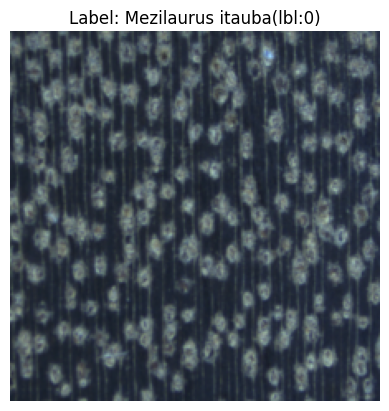

In [75]:
show_image(*dataset_extrapolacion_brasil[230], dataset_extrapolacion_brasil)

# Creación loaders

In [76]:
subset_entorno_abierto = Subset(dataset_entorno_abierto, df_entorno_abierto.index.tolist())
subset_extrapolacion_brasil = Subset(dataset_extrapolacion_brasil, df_extrapolacion_brasil.index.tolist())

In [77]:
loader_entorno_abierto = DataLoader(subset_entorno_abierto, shuffle=False)
loader_extrapolacion_brasil = DataLoader(subset_extrapolacion_brasil, shuffle=False)

# Disponibilidad CPU

In [78]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Clase modelo

In [79]:
from TriAttentionArchitectura import TriAttention

class WoodClassifierWithTriAttention(nn.Module):
    """
        Clase que implementa el mecanismo de atención en la arquitectura (backbone) MobileNetV3.
        Por defecto, use_tri_attention es igual a True, por lo que se implementa el mecanismo al Backbone.
        En caso de ser Falso, simplemente se modifica la última capa. Sin Tri Attention
    """

    def __init__(self, num_classes=4, use_tri_attention=True):
        super().__init__()

        # Se extrae el backbone (completo, con clasificador) de MobileNetV3
        self.backbone = mobilenet_v3_large(weights=weights)

        # Se extraen las características (sin clasificador)
        self.features = self.backbone.features

        # Banderas para aplicar mecanismo de atention
        self.use_tri_attention = use_tri_attention

        # 3 módulos de Tri Attention
        if self.use_tri_attention:
            self.tri_1 = TriAttention(24, reduction_radio=8) # Aplicación en la capa 3
            self.tri_2 = TriAttention(80, reduction_radio=8) # Aplicación en la capa 10
            self.tri_3 = TriAttention(960, reduction_radio=16) # Aplicación en la capa 16 (Ultima antes del clasificador)

        # MODIFICACIÓN CLASIFICADOR FINAL
        # Obtenemos las características de entrada de esa capa Linear
        in_features = self.backbone.classifier[3].in_features
        # Modificamos solo la última capa (la que clasifica) a las característiacs de clasificación = número de clases
        self.backbone.classifier[3] = nn.Linear(in_features=in_features, out_features=num_classes, bias=True)

        # Reducción a [B,C,1,1] (para Tri Attention)
        self.avgpool = nn.AdaptiveAvgPool2d(1)

        # Inicializamos los pesos de TODO la red
        self._initialize_weights()

    def forward(self, x):
        # x -> [B,3,224,224] (Tamaño de entrada para MobileNetV3)

        # En caso 'use_tri_attention' == false. Se hace la clasificación con el modelo original
        if not self.use_tri_attention:
            x = self.backbone(x)
            return x


        # Solo se ejecuta siempre que 'use_tri_attention' == true
        for i, layer in enumerate(self.features):
            # print(f"Capa {i}. Shape entrada: {x.shape}", sep=" ")
            x = layer(x)
            # print(f"Shape salida: {x.shape}")


            if i == 3:
                x = self.tri_1(x)
                # print(f"Tri Attention 1 aplicada: {x.shape}. Capa {i}")
            elif i == 10:
                x = self.tri_2(x)
                # print(f"Tri Attention 2 aplicada: {x.shape}. Capa {i}")
            elif i == 16:
                x = self.tri_3(x)
                # print(f"Tri Attention 3 aplicada: {x.shape}. Capa {i}")

        # Global Avarage Pooling
        x = self.avgpool(x) # [B,C,1,1]
        x = torch.flatten(x, 1) # [B, 960]

        # Clasificación con el clasificador de la arquitectura, puesto que se modificó el original
        x = self.backbone.classifier(x) # [B, [num_clases]]
        return x


    def _initialize_weights(self):
        """
        Inicializa los pesos del clasificador y los módulos de a
        """
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # Kaiming para capas convolucionales
                # Es óptima para funciones de activación ReLU
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                # Para BatchNorm2D -> weight=1 y bias=0 Es el estándar
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                # Para las capas lineales, una configuración pequeña
                nn.init.normal_(m.weight,0 ,0.01)
                nn.init.constant_(m.bias, 0)
        print(f"Inicialización de pesos (Arquitectura MobileNetV3)")

# Cargar modelo

## Modelo entorno abierto

In [ ]:
device = torch.device("cpu")

model = WoodClassifierWithTriAttention(
    num_classes=4,
    use_tri_attention=False
)

state_dict = torch.load(
    "Modelo_E12__CON_aumento_sin_tri.pt",
    map_location=torch.device("cpu")
)

model.load_state_dict(state_dict)
model.to(device)
model.eval()

# Funciones auxiliares

In [90]:
def calcular_métricas(labels, predictions, dataset, average="macro", draw_confusion_matrix=False, phase= "Test"):
    """
    Calcula métricas de evaluación: Recall, F1-score y Accuracy.
    Opcionalmente, muestra la matriz de confusión y la curva ROC.

    Args:
      labels (torch.Tensor | np.ndarray | list[int]):
          Conjunto de etiquetas verdaderas (valores reales de las clases).
          Puede ser un tensor de PyTorch, un arreglo de NumPy o una lista de enteros.

      predictions (torch.Tensor | np.ndarray | list[int]):
          Conjunto de etiquetas predichas por el modelo.
          Debe tener la misma forma que `labels`.

      average (str, opcional):
          Tipo de promedio para calcular `recall` y `f1-score`.
          Ejemplos: `'macro'`, `'micro'`, `'weighted'`.
          Por defecto `'macro'`.

      draw_confusion_matrix (bool, opcional):
          Si es `True`, muestra la matriz de confusión.
          Por defecto `False`.

      phase (str, opcional):
          Indica la fase en la que se calculan las métricas
          (por ejemplo: `'train'`, `'valid'`, `'test'`).
          Si se deja vacío, no imprime las métricas.
          Por defecto `""`.

    Returns:
      recall (float): Valor promedio del *Recall* calculado según `average`.
      f1 (float): Valor promedio del *F1-score* calculado según `average`.
      accuracy (float): Porcentaje de aciertos del modelo.

    """

    # --- Conversión a numpy ---
    # En caso se obtenga un tensor, se convierte con numpy y se pasa a la CPU
    # Sino, se convierte a un array con numpy
    labels = labels.cpu().numpy() if torch.is_tensor(labels) else np.array(labels)
    predictions = predictions.cpu().numpy() if torch.is_tensor(predictions) else np.array(predictions)

     # --- Métricas básicas ---
    # Recall y F1 score están configurados para el average.
    # Zero_division en retorno de 0 para evitar la advertencia
    # (Zero division sucede cuando no clasificó bien ningúna muestra de 1 o más clases.
    # O cuando no hay muestras de esa clase para clasificarlas)
    recall = recall_score(labels, predictions, average=average, zero_division=0)
    f1 = f1_score(labels, predictions, average=average, zero_division=0)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average=average, zero_division=0)

    # Se imprime según la fase (cuando es "valid" o "train")
    if phase != "":
        print(f'\n({phase}) Recall: {recall}')
        print(f'({phase}) F1-score: {f1}')
        print(f'({phase}) Accuracy: {accuracy}')
        print(f'({phase}) Precision: {precision}')
        print("\n")

     # --- Matriz de confusión ---
    # Dibujo de la matriz de confusión. Normalmente se utiliza en la función de Test para observar su clasificación
    if draw_confusion_matrix:
        cm = confusion_matrix(labels, predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(dataset.class_label.keys())) # Se esta accediendo al datset global, camibar y tener cuidado
        disp.plot(cmap="Blues", xticks_rotation=45)
        # path = os.path.join("Entorno abierto/" + "Entorno_abierto_Matriz.jpg")
        path = os.path.join("Extrapolacion/" + "E1__Extrapolacion_CON_aumento_con_tri_Matriz.jpg")
        plt.savefig(path, format='jpg')  # Guarda como jpg
        print(f"Gráfico guardado como: {path}")

        plt.show()

    return recall, f1, accuracy, precision

In [88]:
def test_model(model, test_loader, dataset, num_valid_classes=4):
    """
    Evalúa una lista de modelos con el conjunto de prueba (no visto en entrenamiento).

    Args:
        models_ft (list[torch.nn.Module]): Lista de modelos entrenados (por fold o ensemble).
        test_loader (torch.utils.data.DataLoader): Dataloader del conjunto de prueba.
        df_test (pd.DataFrame): DataFrame para almacenar métricas del test.
        file_name_best_model (str): Nombre de archivo para guardar el mejor modelo.

    Returns:
        best_model (torch.nn.Module): Modelo con mejor desempeño en test.
    """

    model.eval()  # Se cambia a modo evaluación

    all_labels = []
    all_preds = []

    # Se desactiva la gradiante. Puesto que es Test
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

             # Forward pass
            # Ejecución del modelo y predicciones
            outputs = model(inputs)
            outputs = outputs[:, :num_valid_classes] # ignora la clase más alla del limite
            _, preds = torch.max(outputs, 1)

            # Acumular todos los labels y predicciones
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calcular métricas
    calcular_métricas(all_labels,
                    all_preds,
                    dataset,
                    draw_confusion_matrix=True
                    )

# Matriz confusión Entorno abierto


(Test) Recall: 0.8103448275862069
(Test) F1-score: 0.8062083419226276
(Test) Accuracy: 0.8103448275862069
(Test) Precision: 0.8259618441971383


Gráfico guardado como: Extrapolacion/E1__Extrapolacion_CON_aumento_con_tri_Matriz.jpg


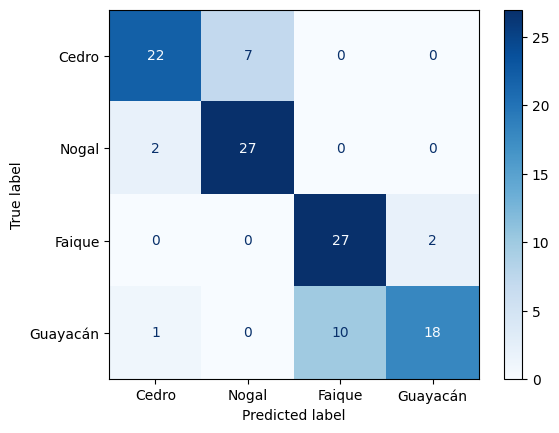

In [83]:
# Entorno abierto
test_model(model=model, test_loader=loader_entorno_abierto, dataset=dataset_entorno_abierto)



(Test) Recall: 0.3333333333333333
(Test) F1-score: 0.21037037037037035
(Test) Accuracy: 0.3169642857142857
(Test) Precision: 0.15367965367965367


Gráfico guardado como: Extrapolacion/E1__Extrapolacion_CON_aumento_con_tri_Matriz.jpg


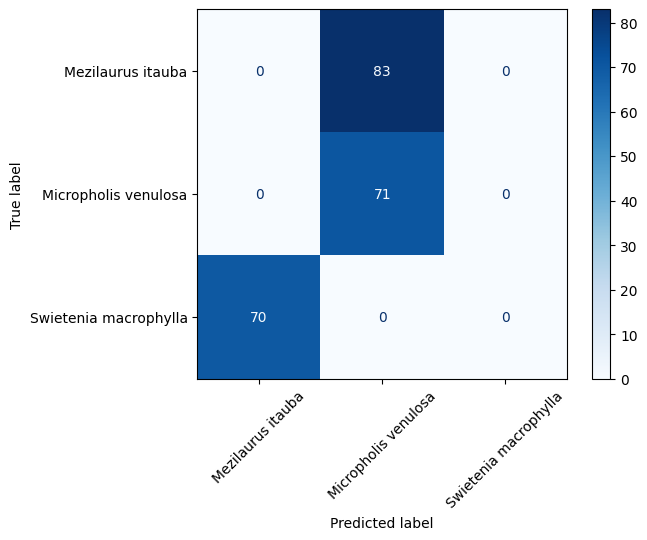

In [91]:
# Extrapolacion brasil
# IMPORTANTE: Recuerda cambiar la ruta de guardado
test_model(model=model, test_loader=loader_extrapolacion_brasil,  dataset=dataset_extrapolacion_brasil, num_valid_classes=3)

## T-SNE para extrapolación brasil

In [92]:

class MobileNetV3FeatureExtractor(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        # Tomamos todo el classifier excepto la última capa (que produce las 4 clases)
        self.feature_layer = nn.Sequential(*list(self.model.backbone.classifier.children())[:-1])

    def forward(self, x):
        # Paso por el backbone hasta avgpool
        x = self.model.features(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)  # aplanamos a (batch_size, 960)
        # Paso por el classifier hasta la penúltima capa
        x = self.feature_layer(x)  # ahora x tiene forma (batch_size, 1280)
        return x

In [93]:
# Supongamos que `model` es tu MobileNetV3 entrenado
extractor = MobileNetV3FeatureExtractor(model)
extractor.eval()

all_features = []
all_labels = []

with torch.no_grad():
    for images, labels in loader_extrapolacion_brasil:
        images = images.to(device) 
        features = extractor(images)
        features = features[:,:3] # porque el dataset de brasil solo tiene 3 especies
        all_features.append(features.cpu())
        all_labels.append(labels.cpu())

# Concatenamos todos los batches
all_features = torch.cat(all_features, dim=0)  # (num_samples, 1280)
all_labels = torch.cat(all_labels, dim=0)      # (num_samples,)


In [94]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(all_features.numpy())

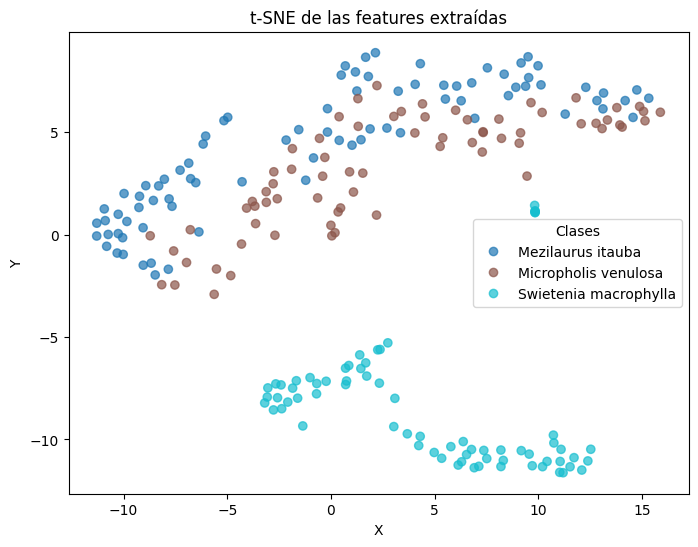

In [95]:
classes = {0: 'Mezilaurus itauba', 1: 'Micropholis venulosa', 2: 'Swietenia macrophylla'}

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=all_labels.numpy(),
    cmap='tab10',
    alpha=0.7
)

# Leyendas
handles, _ = scatter.legend_elements()
plt.legend(handles, [classes[i] for i in range(len(classes))], title="Clases")

plt.savefig("TSNE_aumento_atencion.png", dpi=300)
plt.title("t-SNE de las features extraídas")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


## Grad CAM - Mapa de calor - Extrapolación Brasil

In [96]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer

        self.gradients = None
        self.activations = None

        # Hooks seguros (backward-hook deprecated → usar register_full_backward_hook)
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_full_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_heatmap(self):
        grads = self.gradients
        activations = self.activations

        # GAP en gradientes → pesos por canal
        weights = grads.mean(dim=(2, 3), keepdim=True)

        # CAM
        cam = (weights * activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)

        # Normalizar y convertir a imagen
        cam = cam.squeeze().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam


def apply_gradcam(model, img_tensor, device, target_layer):
    model.eval()
    img_tensor = img_tensor.unsqueeze(0).to(device)

    gradcam = GradCAM(model, target_layer)

    # Forward
    output = model(img_tensor)
    class_idx = output.argmax().item()

    # Backward
    model.zero_grad()
    output[0, class_idx].backward()

    cam = gradcam.generate_heatmap()

    # Imagen original
    img = img_tensor[0].permute(1, 2, 0).detach().cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    # Heatmap
    heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heatmap = heatmap[..., ::-1] / 255.0  # BGR → RGB

    # Superposición
    superimposed = 0.4 * heatmap + 0.6 * img
    superimposed = np.clip(superimposed, 0, 1)

    return img, heatmap, superimposed


Micropholis venulosa


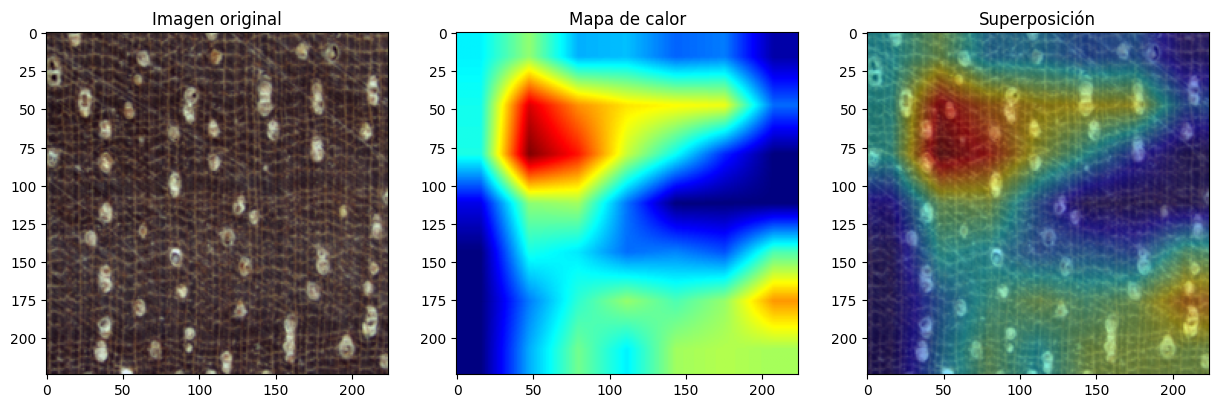

In [108]:
dataset = loader_extrapolacion_brasil.dataset

idx = 110  # imagen número 123 del dataset completo
img_tensor, label = dataset[idx]
print(classes[label])

target_layer = model.backbone.features[16][0]

img, heat, superimposed = apply_gradcam(model, img_tensor, device, target_layer)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1); plt.imshow(img); plt.title("Imagen original")
plt.subplot(1, 3, 2); plt.imshow(heat); plt.title("Mapa de calor")
plt.subplot(1, 3, 3); plt.imshow(superimposed); plt.title("Superposición")
plt.savefig("Extrapolacion/GRAD_CAM_Micropholis venulosa.png", dpi=300) # Guardar imágen
plt.show()